# PM2.5 Statistical Prediction Models_Modeling_8_ARIMA_diff

## Quick Summary

### Key problems:
* How to choose the hyperparameters for the ARIMA and SARIMA models from ACF and PACF plots?<br>
* Why in all cases, the performance on the training set is good but the performance on the test set is very bad? Am I doing anything wrong? <br>
* SARIMA model takes a long time to train for the hourly dataset (at the end of notebook 5) <br>
* Taking the difference to remove trends and un-differencing after the model fitting and predictions alway mess up the data (see notebook 7 and 8 where the target variable is first differenced before applying the ARIMA model) <br>

### Introduction to the notebooks: 
Four notebooks are developed to test out the ARIMA and SARIMA models for various sampling frequencies:
modeling_5_ARIMA_hourly, modeling_6_ARIMA_daily, modeling_7_ARIMA_monthly and modeling_8_ARIMA_diff.<br> 
* (notebook_5) Hourly data: the hourly PM2.5 for Beijing is extracted and both ARIMA model and SARIMA model are attempted. SARIMA model takes a really long time to compute (>1day) so the result is not available.<br> 
* (notebook_6) Daily data: the hourly data is resampled by day and both ARIMA model and SARIMA model are used. <br>
* (notebook_7) Monthly data: the hourly data is resampled by month. Due to the non-stationarity, the monthly data is first transformed towards stationarity by taking the difference, then feed to the ARIMA model. Due to the limited data size in the monthly data, SARIMA is not used. <br>
* (notebook_8): in this notebook, the hourly data is first differenced to remove the underlying trend before feeding to the ARIMA model. The predicted results is then un-differenced to recover to the original scale. <br>

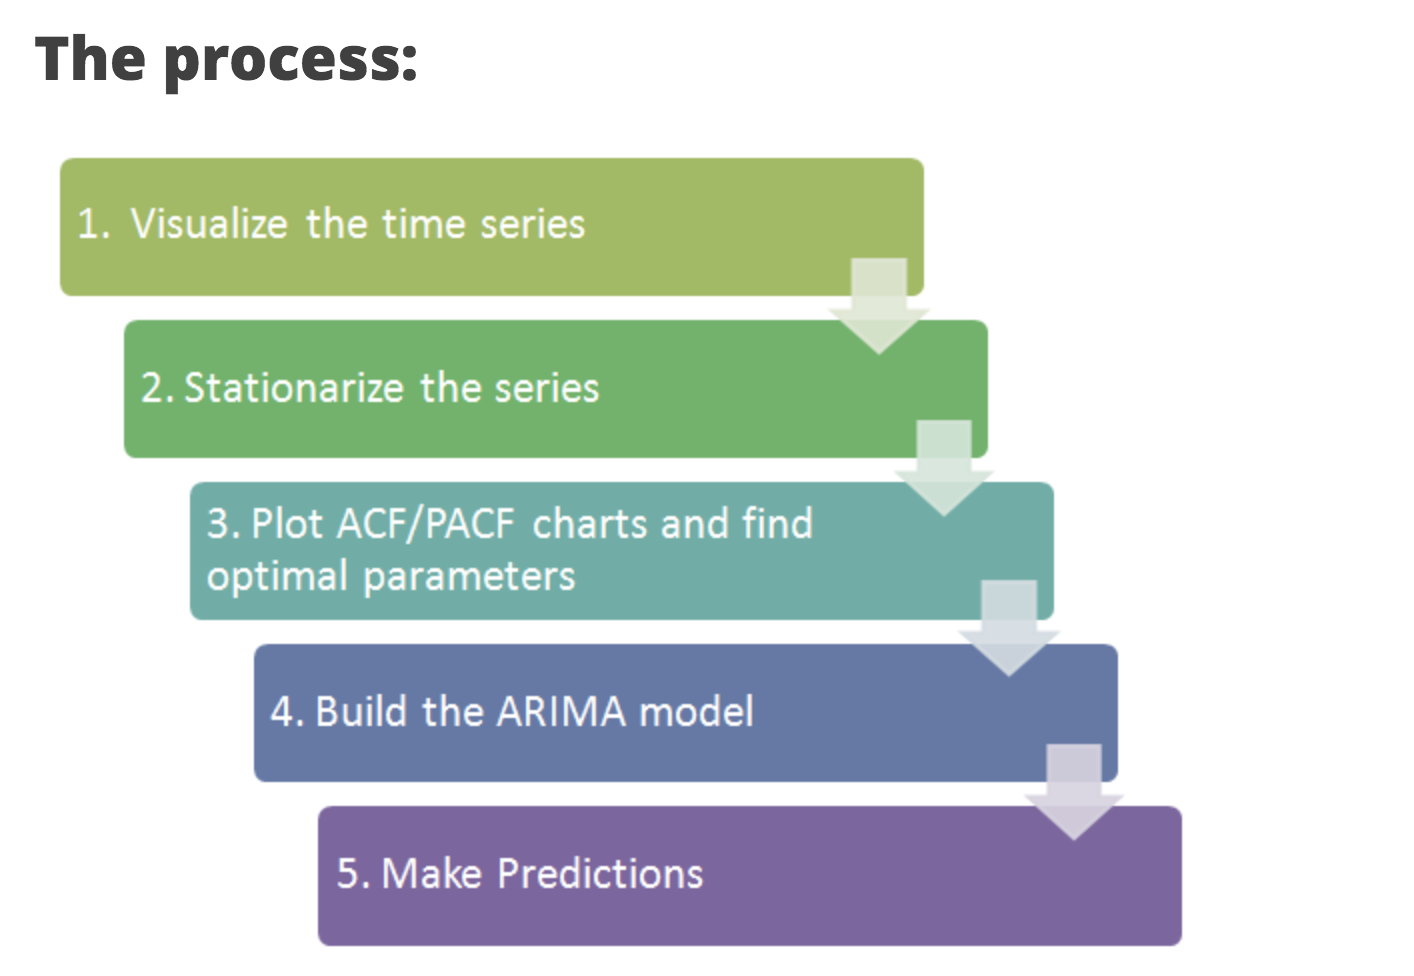

In [1]:
# import relevant module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#import pm_clean from 'pm_clean.csv' file and parse the strings in 'date_time' column into DateTime objects

pm_clean = pd.read_csv('pm_clean.csv',index_col=0, parse_dates=['date_time'])
print(pm_clean.head(1))

   year  month  day  hour  season  dewp  humi    pres  temp cbwd   iws  \
0  2010      1    1    23       4 -17.0  41.0  1020.0  -5.0   CV  0.89   

   precipitation  iprec     city  pm_average           date_time    ws  
0            0.0    0.0  beijing       129.0 2010-01-01 23:00:00  0.89  


In [3]:
# use a subset of one city (city Beijing) to explore for now
bj = pm_clean[pm_clean['city'] == 'beijing']

# extract the time series 'pm_average' data only
bj_hourly = bj[['pm_average','date_time']]
print(bj_hourly.head())

   pm_average           date_time
0       129.0 2010-01-01 23:00:00
1       148.0 2010-01-02 00:00:00
2       159.0 2010-01-02 01:00:00
3       181.0 2010-01-02 02:00:00
4       138.0 2010-01-02 03:00:00


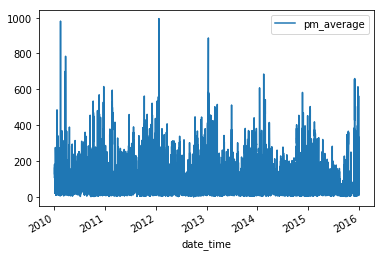

In [4]:
# plot the time series to inspect the features
bj_hourly.set_index('date_time').plot();

As shown, there is a significant seasonality component and a minor downward trend in the time series data.
Need to be transformed to stationary data for ARIMA model. 

### Transform the data

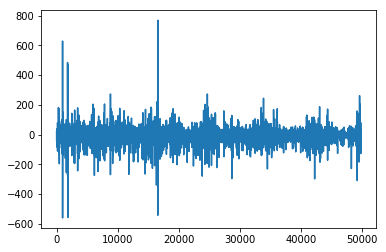

In [5]:
# detrend/tranform the data by taking the logrithmic scale and then taking the difference

bj_hourly_transformed = bj_hourly['pm_average'].diff(1).dropna()
bj_hourly_transformed.plot();

### Test for stationarity
In order to use an ARIMA model, the Dickey-Fuller Test is conducted on the transformed hourly dataset to determine if it is stationary (constant mean, variance and autocorrelation across the time series dataset).
 
<li>$H_o$: Non-stationary series
<li>$H_a$: Stationary series

In [6]:
# http://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.stattools.adfuller.html

useful_values_raw = adfuller(bj_hourly_transformed, autolag = 'AIC', regression = 'c')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%'], 'Value':useful_values})

,Label,Value
0,Test Statistic,-39.461056
1,p-value,0.000000
2,#Lags Used,57.000000
3,Number of Observations Used,49795.000000
4,Critical value for 1%,-3.430481
5,Critical value for 5%,-2.861598
6,Critical value for 10%,-2.566801


p-value is 0.000000, we can reject the null hypothesis of non-stationarity. Therefore, as the test concludes, the tranformed time series is now stationary and the ARIMA model can be used.

### acf and pacf plots for identifying the model parameters

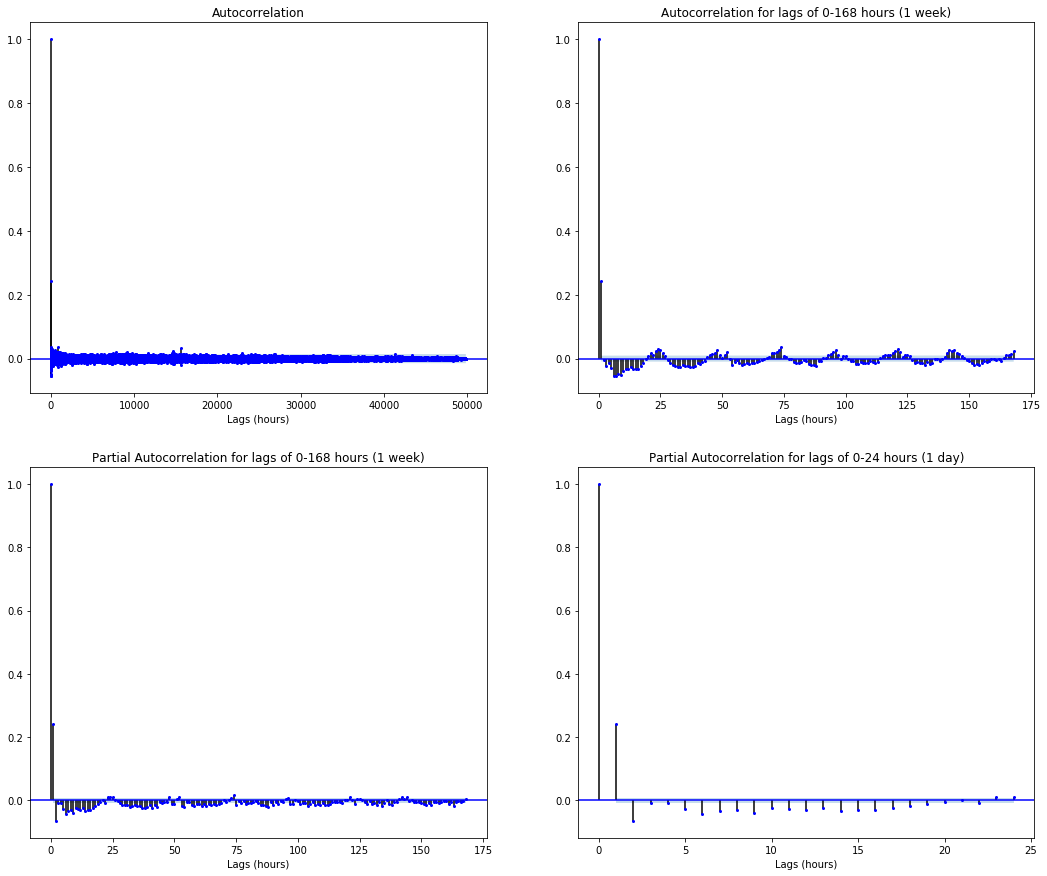

In [7]:
# look at the autocorrelation and partial autocorrelation plots to identify potential structure in the time series data

fig = plt.figure(figsize=(18,15));

ax1 = fig.add_subplot(221)
plot_acf(bj_hourly_transformed, ax=ax1, color='blue',markersize=2);
ax1.set_xlabel('Lags (hours)');

ax2 = fig.add_subplot(222)
plot_acf(bj_hourly_transformed,lags=168, ax=ax2, title='Autocorrelation for lags of 0-168 hours (1 week)', color='blue',markersize=2);
ax2.set_xlabel('Lags (hours)');

ax3 = fig.add_subplot(223)
plot_pacf(bj_hourly_transformed, lags=168, ax=ax3, title='Partial Autocorrelation for lags of 0-168 hours (1 week)', color='blue', markersize=2);
ax3.set_xlabel('Lags (hours)');

ax4 = fig.add_subplot(224)
plot_pacf(bj_hourly_transformed, lags=24, ax=ax4, title='Partial Autocorrelation for lags of 0-24 hours (1 day)', color='blue', markersize=2);
ax4.set_xlabel('Lags (hours)');

As the plots and data transformation reveal, the parameters for the ARIMA model should be: 
1. The number of Auto-Regressive Terms based on the pacf plot: p=1 or p=2
2. The number of differences taken based on the data transformation: d=1
3. The number of Moving Average Terms based on the acf plot: q=1

### ARIMA model with p=1, d=1 and q=1

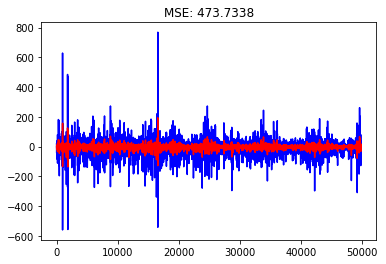

In [14]:
model_1 = ARIMA(bj_hourly['pm_average'], order=(1, 1, 1))  
results_1 = model_1.fit(disp=-1)  
plt.plot(bj_hourly_transformed, color='blue');
plt.plot(results_1.fittedvalues, color='red');
plt.title('MSE: {:.4f}'.format(np.mean((results_1.fittedvalues-bj_hourly_transformed)**2)));

### un-difference and un-log to recover the predicted PM2.5 values

1     0.002300
2     4.618707
3     6.382379
4    11.635486
5    -0.629367
dtype: float64


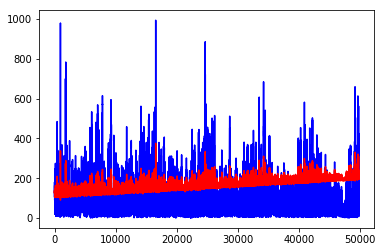

In [15]:
predictions_1_diff = pd.Series(results_1.fittedvalues, copy=True)
predictions_1_diff_cumsum = predictions_1_diff.cumsum()
print(predictions_1_diff_cumsum.head())

predictions_1 = pd.Series(bj_hourly.loc[0,'pm_average'], index=bj_hourly.index)
predictions_1 = predictions_1.add(predictions_1_diff_cumsum, fill_value=0)
plt.plot(bj_hourly['pm_average'], color='blue');
plt.plot(predictions_1, color='red');

### ARIMA model with p=2, d=1 and q=1

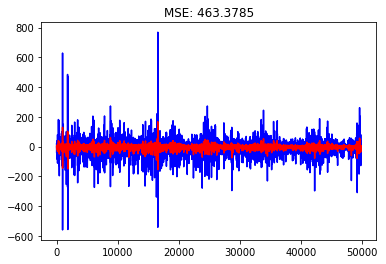

In [16]:
model_2 = ARIMA(bj_hourly['pm_average'], order=(2, 1, 1))  
results_2 = model_2.fit(disp=-1)  
plt.plot(bj_hourly_transformed, color='blue');
plt.plot(results_2.fittedvalues, color='red');
plt.title('MSE: {:.4f}'.format(np.mean((results_2.fittedvalues-bj_hourly_transformed)**2)));

### un-difference and un-log to recover the predicted PM2.5 values

1     0.000681
2     4.595906
3     6.822110
4    11.555357
5    -0.211788
dtype: float64


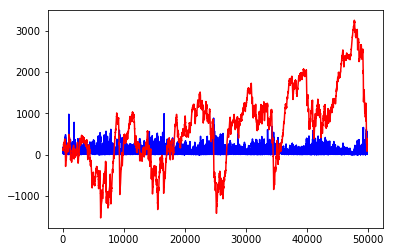

In [17]:
predictions_2_diff = pd.Series(results_2.fittedvalues, copy=True)
predictions_2_diff_cumsum = predictions_2_diff.cumsum()
print(predictions_2_diff_cumsum.head())

predictions_2 = pd.Series(bj_hourly.loc[0,'pm_average'], index=bj_hourly.index)
predictions_2 = predictions_2.add(predictions_2_diff_cumsum, fill_value=0)
plt.plot(bj_hourly['pm_average'], color='blue');
plt.plot(predictions_2, color='red');

### ARIMA model with p=1, d=0 and q=1
(without differencing)

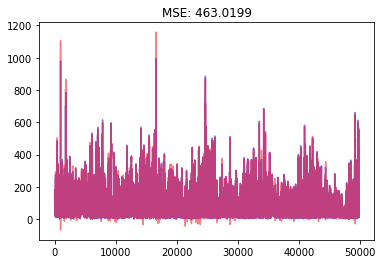

In [18]:
model_3 = ARIMA(bj_hourly['pm_average'], order=(1, 0, 1))  
results_3 = model_3.fit(disp=-1)  
plt.plot(bj_hourly['pm_average'], color='blue', alpha=0.5);
plt.plot(results_3.fittedvalues, color='red',alpha=0.5);
plt.title('MSE: {:.4f}'.format(np.mean((results_3.fittedvalues-bj_hourly['pm_average'])**2)));